In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from transformers import TFBertForSequenceClassification

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fake_df = pd.read_csv('/content/drive/MyDrive/deeplearning/deep_learning_aie/Fake.csv')
real_df = pd.read_csv('/content/drive/MyDrive/deeplearning/deep_learning_aie/True.csv')

In [ ]:
real_df.shape

(21417, 4)

In [ ]:
# Sample 1000 rows from real_df
real_df_sample = real_df.sample(n=10000, random_state=42)

# Save the sample to a CSV file
real_df_sample.to_csv('real_news_.csv', index=False)


In [ ]:
real_df_sample.shape

(10000, 4)

In [ ]:
real_df_sample.subject.unique()

array(['worldnews', 'politicsNews'], dtype=object)

In [ ]:
# Sample 1000 rows from real_df
fakel_df_sample = fake_df.sample(n=10000, random_state=42)

# Save the sample to a CSV file
fakel_df_sample.to_csv('fake_news_.csv', index=False)



In [ ]:
fakel_df_sample.shape

(10000, 4)

In [ ]:
fakel_df_sample.subject.unique()

array(['politics', 'left-news', 'News', 'Middle-east', 'Government News',
       'US_News'], dtype=object)

In [ ]:
fakel_df_sample.drop(['date', 'subject'], axis=1, inplace=True)
real_df_sample.drop(['date', 'subject'], axis=1, inplace=True)

In [ ]:
fakel_df_sample['class'] = 0
real_df_sample['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

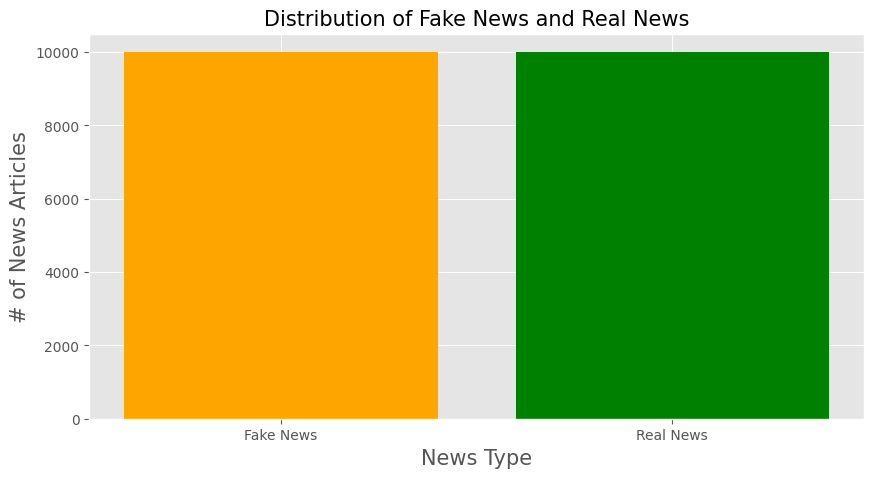

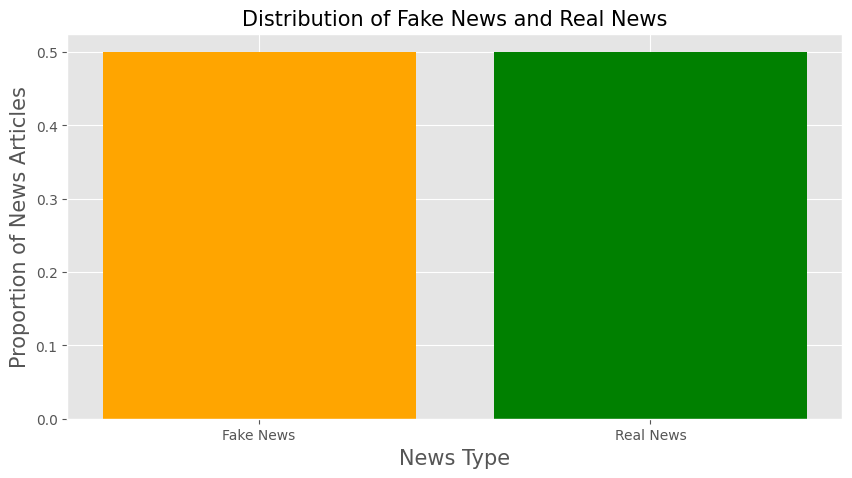

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fakel_df_sample), color='orange')
plt.bar('Real News', len(real_df_sample), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fakel_df_sample) + len(real_df_sample)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fakel_df_sample) / total_len, color='orange')
plt.bar('Real News', len(real_df_sample) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [ ]:
news_df = pd.concat([fakel_df_sample , real_df_sample], ignore_index=True, sort=False)

In [ ]:
news_df.head()

,title,text,class
0,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,0
1,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,0
2,‘SLEEPY’ JUSTICE GINSBURG: Excites Crowd By Sa...,So much for the SCOTUS not being political Che...,0
3,WATCH: Kellyanne Conway Very Upset Hillary Cl...,White House counselor Kellyanne Conway crawled...,0
4,"GOP Gives Trump The Middle Finger, Prepares T...",Donald Trump may have decided that Russia is g...,0


In [ ]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [ ]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [ ]:
import re

# Precompile regex patterns
url_pattern = re.compile(r'https?://\S+|www\.\S+')
non_word_pattern = re.compile(r'\W')
newline_pattern = re.compile(r'\n')
extra_space_pattern = re.compile(r' +')
leading_space_pattern = re.compile(r'^ ')
trailing_space_pattern = re.compile(r' $')

def normalize(data):
    return [
        trailing_space_pattern.sub('',
        leading_space_pattern.sub('',
        extra_space_pattern.sub(' ',
        newline_pattern.sub('',
        non_word_pattern.sub(' ',
        url_pattern.sub('', i.lower()))))))
        for i in data
    ]

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [ ]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=8, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 629s 344ms/step - accuracy: 0.7184 - loss: 0.4563 - val_accuracy: 0.9613 - val_loss: 0.1270
Epoch 2/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 608s 336ms/step - accuracy: 0.9542 - loss: 0.1277 - val_accuracy: 0.9438 - val_loss: 0.1590
Epoch 3/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 623s 337ms/step - accuracy: 0.9816 - loss: 0.0669 - val_accuracy: 0.9781 - val_loss: 0.0641
Epoch 4/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 614s 341ms/step - accuracy: 0.9901 - loss: 0.0366 - val_accuracy: 0.9712 - val_loss: 0.1040
Epoch 5/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 611s 339ms/step - accuracy: 0.9857 - loss: 0.0537 - val_accuracy: 0.9806 - val_loss: 0.0633
Epoch 6/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 616s 336ms/step - accuracy: 0.9944 - loss: 0.0274 - val_accuracy: 0.9825 - val_loss: 0.0571
Epoch 7/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 612s 340ms/step - accuracy: 0.9963 - loss: 0.0149 - val_accuracy: 0.9819 - val_loss: 0.0546
Epoch 8/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 616s 337ms/step - ac

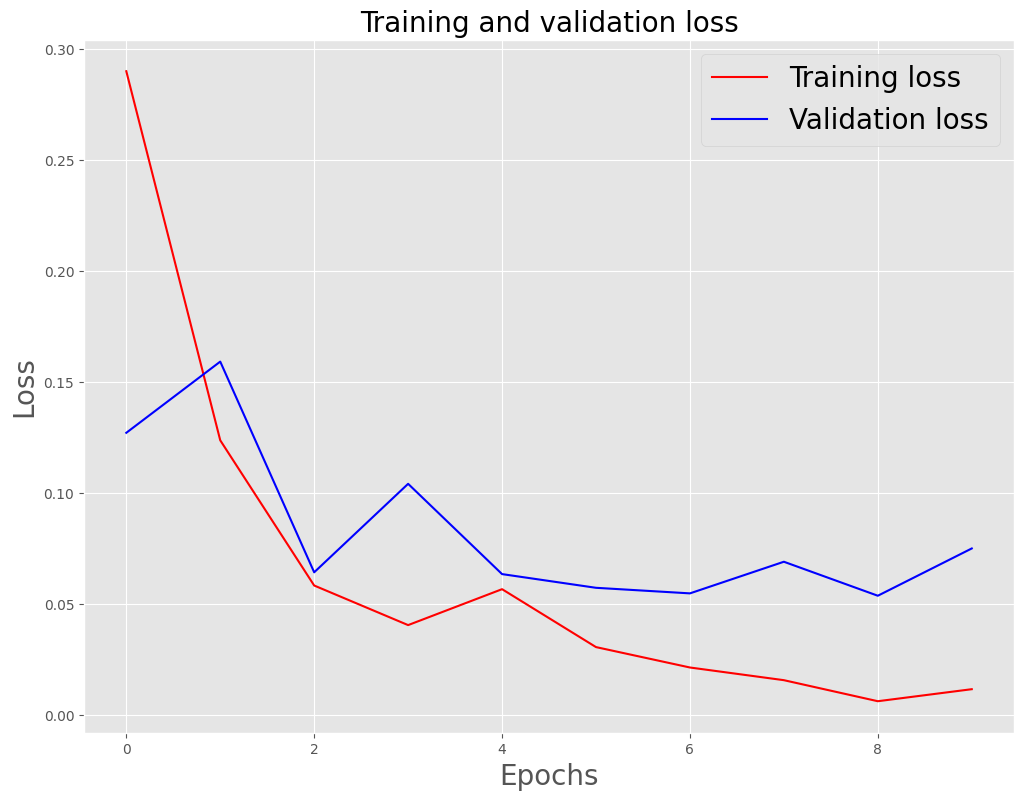

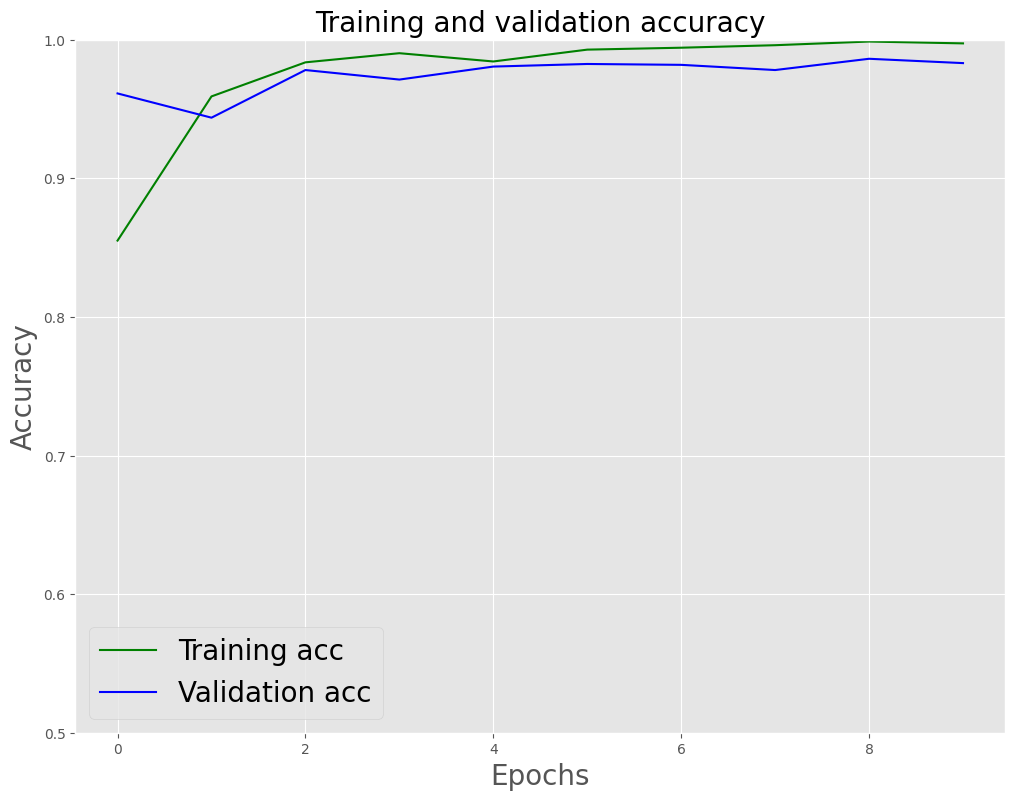

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.9786 - loss: 0.0922


[0.09381768852472305, 0.9789999723434448]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step


In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.979
Precision on testing set: 0.9769076305220884
Recall on testing set: 0.9808467741935484


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

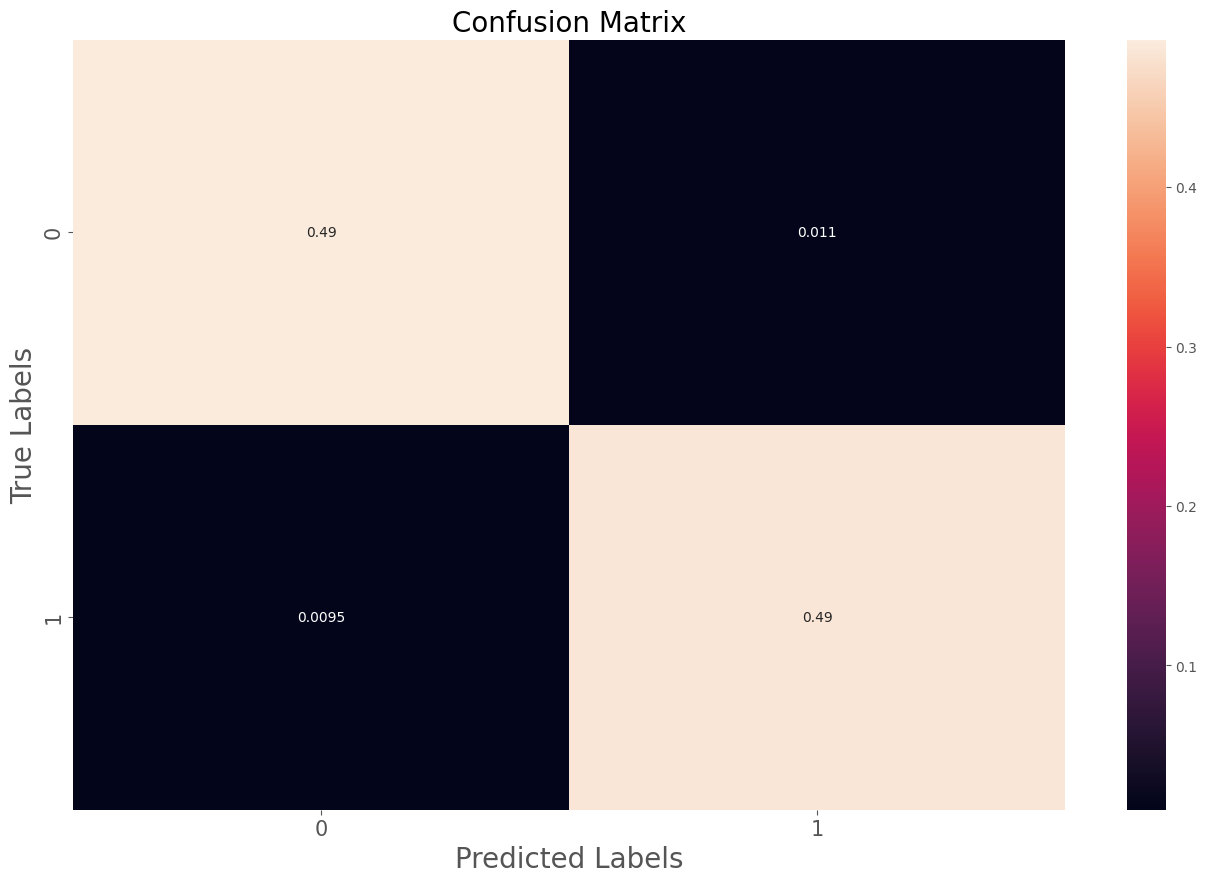

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

**เรียกใช้โมเดล**

In [ ]:
import numpy as np

def preprocess_text(news_text, tokenizer, max_length=200):
    # แปลงข้อความเป็นลำดับตัวเลข
    sequence = tokenizer.texts_to_sequences([news_text])
    # เติม Padding ให้มีขนาดเท่ากับ max_length
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length)
    return padded_sequence


In [ ]:
def predict_news(news_text):
    # แปลงข้อความให้เป็นรูปแบบที่โมเดลเข้าใจ
    processed_text = preprocess_text(news_text, tokenizer)

    # ใช้โมเดลทำนาย
    prediction = model.predict(processed_text)[0][0]

    # แสดงผลลัพธ์
    return "Fake News" if prediction >= 0.5 else "Real News"


In [ ]:
news = "Breaking: Government announces new economic policy."
result = predict_news(news)
print("📰 Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
📰 Prediction: Real News
